In [44]:
import sys
!{sys.executable} -m pip install statsbombpy
from statsbombpy import sb


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
comps = sb.competitions()
# comps[comps["competition_name"]=="Premier League"]
# comps.sort_values(by="season_name",ascending=False).head(10)
# comp_match_counts = {}
# for _, row in comps.sort_values(by="season_name",ascending=False).head(20).iterrows():
#     matches = sb.matches(row["competition_id"], row["season_id"])
#     comp_match_counts[f"{row['competition_name']} ({row['season_name']})"] = len(matches)
# comp_match_counts


c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [46]:
comps[comps["competition_name"]=="UEFA Euro"]
sb.matches(55, 282)
sb.events(3942819)['type'].value_counts()


c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


type
Pass                 1065
Ball Receipt*        1020
Carry                 910
Pressure              173
Ball Recovery          55
Duel                   46
Block                  27
Foul Won               23
Foul Committed         23
Goal Keeper            19
Miscontrol             16
Interception           16
Shot                   16
Dispossessed           14
Dribble                12
Clearance              12
Substitution            9
Injury Stoppage         5
Half Start              4
Half End                4
Bad Behaviour           3
Dribbled Past           3
Referee Ball-Drop       2
50/50                   2
Tactical Shift          2
Starting XI             2
Player On               1
Player Off              1
Name: count, dtype: int64

In [47]:
comps[comps["competition_name"]=="Premier League"]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
64,2,27,England,Premier League,male,False,False,2015/2016,2024-06-12T07:43:56.243851,2021-06-13T16:17:31.694,None,2024-06-12T07:43:56.243851
65,2,44,England,Premier League,male,False,False,2003/2004,2024-03-08T14:49:13.195793,2021-06-13T16:17:31.694,None,2024-03-08T14:49:13.195793


In [48]:
print("Amount of Games: ",sb.matches(2,27).shape[0])
matches = sb.matches(2,27)
match = matches.iloc[1]
home_team = match.home_team
away_team = match.away_team
match_id = match.match_id
match

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


Amount of Games:  380


c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


match_id                                    3754245
match_date                               2015-10-17
kick_off                               16:00:00.000
competition                England - Premier League
season                                    2015/2016
home_team                      West Bromwich Albion
away_team                                Sunderland
home_score                                        1
away_score                                        0
match_status                              available
match_status_360                          scheduled
last_updated             2022-12-01T13:09:17.044015
last_updated_360            2021-06-13T16:17:31.694
match_week                                        9
competition_stage                    Regular Season
stadium                               The Hawthorns
referee                             Martin Atkinson
home_managers                            Tony Pulis
away_managers                         Sam Allardyce
data_version

In [49]:
ordered_events =  sb.events(match_id).sort_values(by=["period","timestamp"],ascending=[True,True])

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [50]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
import pandas as pd

In [51]:
ordered_events

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 442, 'lineup': [{'player': {'id'...",West Bromwich Albion,27,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Sunderland,41,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Sunderland,41,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,West Bromwich Albion,27,00:00:00.000,Half Start,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,West Bromwich Albion,27,00:00:00.767,Pass,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,West Bromwich Albion,27,00:48:23.877,Pass,True
2542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Sunderland,41,00:48:24.577,Pressure,NaN
1700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,West Bromwich Albion,27,00:48:24.602,Ball Receipt*,True
3068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Sunderland,41,00:48:26.873,Half End,NaN


# Preprocessing

In [52]:
ordered_events = ordered_events[~ordered_events["location"].isna()]

outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
events = {
    "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
       'Pass Offside'}}, 'end_loc': 'pass_end_location'},
    "Carry": {'end_loc': 'carry_end_location'},
    "Ball Recovery": {"outcome": {'col':'ball_recovery_recovery_failure',False:{True}}},
    "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
    "Clearance": {},
    "Miscontrol": {},
    "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
    "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
    "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
    "Foul Committed": {}
}
cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
cols =sorted(cols)
ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

#make one outcome column
def get_outcome(row):
    event_type = row["type"]
    event_dict = events.get(event_type)
    if "outcome" in event_dict:
        outcome_col = event_dict["outcome"]["col"]
        if row.get(outcome_col, None) in event_dict["outcome"][False]:
            return 0
        return 1

    return np.nan

ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
ordered_events['outcome'].unique()


#make one end_loc column
def get_end_loc(row):
    event_type = row["type"]
    event_dict = events.get(event_type)
    if "end_loc" in event_dict:
        return row.get(event_dict["end_loc"], None)
    return np.nan

ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)

#change type of event for special pass types
special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]

In [53]:
# Split events by team
away_team_df = ordered_events[ordered_events["team"] == away_team].copy()
home_team_df = ordered_events[ordered_events["team"] == home_team].copy()

# Function to flip coordinates
def flip_coordinates(coords):
    if isinstance(coords, list):
        return [120 - coords[0], 80 - coords[1]]
    return coords

# Flip all coordinate columns for away team
coordinate_columns = ["location", "end_loc"]
for column in coordinate_columns:
    away_team_df[column] = away_team_df[column].apply(flip_coordinates)

# Combine home and away events
ordered_events = pd.concat([home_team_df, away_team_df])


# Visualizing Passes

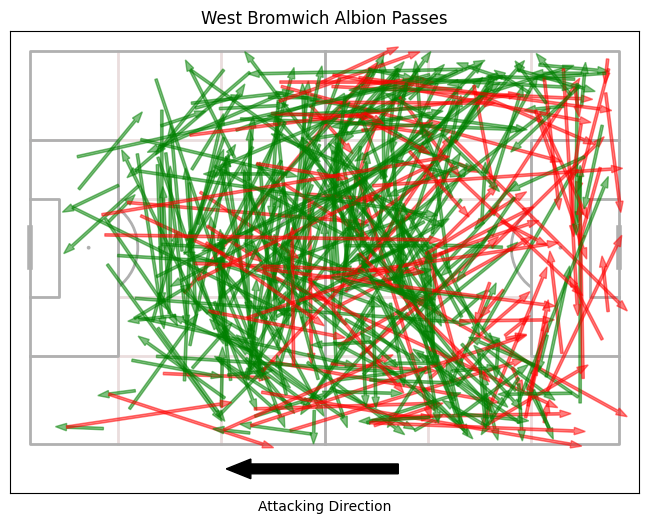

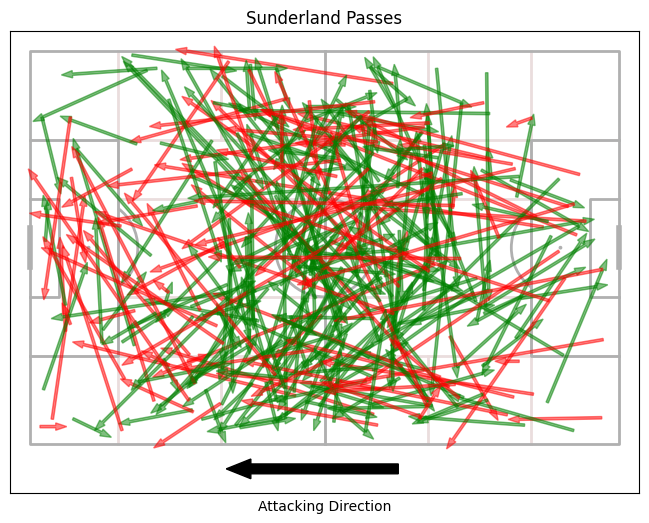

In [54]:
teams = [home_team,away_team]
for team in teams:
    pitch = Pitch(positional=True, axis=True,pad_bottom=10)
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)
    passes = ordered_events[(ordered_events["type"]=="Pass") & (ordered_events["team"] == team)]
    for i in range(len(passes)):
        row = passes.iloc[i]
        x, y = row["location"]
        x_end, y_end = row["end_loc"]
        result = row["outcome"]
        color = 'g' if result else 'r'
        plt.arrow(x, y, x_end-x, y_end-y, color=color, alpha=0.5, width=0.5, ls='-')
    plt.title(f"{team} Passes")
    plt.xlabel("Attacking Direction")
    # Add attacking direction arrows using ax instead of plt
    if team == "AFC Bournemouth":
        ax.arrow(45, 85, 30, 0, head_width=4, head_length=5, fc='black', ec='black', width=2)
    else:
        ax.arrow(75, 85, -30, 0, head_width=4, head_length=5, fc='black', ec='black', width=2)
    plt.show()

# Visualizing Possessions

In [55]:
ordered_events[ordered_events["possession"]==7][["type","pass_outcome","pass_type","duel_outcome","team","possession_team"]]

,type,pass_outcome,pass_type,duel_outcome,team,possession_team
2873,Clearance,NaN,NaN,NaN,West Bromwich Albion,Sunderland
2874,Clearance,NaN,NaN,NaN,West Bromwich Albion,Sunderland
45,Throw-in,NaN,Throw-in,NaN,Sunderland,Sunderland
1735,Carry,NaN,NaN,NaN,Sunderland,Sunderland
46,Pass,NaN,NaN,NaN,Sunderland,Sunderland
47,Pass,NaN,NaN,NaN,Sunderland,Sunderland
2942,Miscontrol,NaN,NaN,NaN,Sunderland,Sunderland
1736,Carry,NaN,NaN,NaN,Sunderland,Sunderland
2585,Ball Recovery,NaN,NaN,NaN,Sunderland,Sunderland
48,Pass,Pass Offside,NaN,NaN,Sunderland,Sunderland


In [56]:
def plot_possession(possession):
    possession_events = ordered_events[ordered_events["possession"] == possession]
    team = possession_events["possession_team"].unique()[0]
    
    # Create pitch visualization
    pitch = Pitch(positional=True, axis=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)
    
    # Sort events by timestamp and calculate width increment
    possession_events = possession_events.sort_values(by=["timestamp"], ascending=True)
    min_width = .5
    max_width = 5
    width_increment = (max_width - min_width) / len(possession_events)
    
    # Get first and last event locations
    first_event = possession_events.iloc[0]
    last_event = possession_events.iloc[-1]
    start_x, start_y = first_event["location"]
    end_x, end_y = last_event["location"]
    
    # Plot each event
    j=0
    for i, event in possession_events.iterrows():
        x, y = event["location"]
        event_team = event["team"]
        width = min_width + j * width_increment
        marker_size = 4 + j * 2

        if event["type"] in ["Goal Kick","Corner", "Free Kick", "Throw-in"] and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            color = 'k'
            linestyle = (0, (4, 4, 4, 4)) if event["type"] == "Throw-in" else '-'
            if event_team != team:
                color = 'gray'
            plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls=linestyle)
            
        elif event["type"] == "Pass" and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            color = 'g' if event["outcome"] else 'r'
            if event_team != team:
                color = 'gray'
            plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls='-')
            
        elif event["type"] == "Shot":
            plt.plot(x, y, 'y*', markersize=marker_size)
            
        elif event["type"] == "Ball Recovery":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}^', markersize=marker_size)
            
        elif event["type"] == "Carry" and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            plt.plot([x, end_x], [y, end_y], color='gray', alpha=0.5, linewidth=1+j, linestyle='--')
            
        elif event["type"] == "Duel":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'  # Opponent won duel = red
            else:
                color = 'r' if not event["outcome"] else 'g'  # Team won duel = green
            plt.plot(x, y, f'{color}o', markersize=marker_size)
            
        elif event["type"] == "Foul Committed":
            if event_team != team:
                color = 'g' if event["outcome"] else 'r'
            else:
                color = 'r' if event["outcome"] else 'g'
            plt.plot(x, y, f'{color}*', markersize=marker_size)
            
        elif event["type"] == "Clearance":
            plt.plot(x, y, 'm^', markersize=marker_size)

        elif event["type"] == "Interception":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}x', markersize=marker_size)
            
        elif event["type"] == "Dribble":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}D', markersize=marker_size)
            
        elif event["type"] == "Miscontrol":
            plt.plot(x, y, 'k+', markersize=marker_size)
            
        j+=width_increment
    
    # Add start and end text annotations
    offset = 5
    start_offset = offset if start_y > 40 else -offset
    end_offset = offset if end_y > 40 else -offset
    plt.annotate('START', xy=(start_x, start_y), xytext=(start_x+2, start_y+start_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    plt.annotate('END', xy=(end_x, end_y), xytext=(end_x+2, end_y+end_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    
    # Add title after annotations to ensure it's on top
    plt.title(f"{team} Possession {possession}", pad=35)  # Added padding to avoid overlap
            
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='g', marker='>', linestyle='-', label='Successful Pass', alpha=0.5),
        plt.Line2D([0], [0], color='r', marker='>', linestyle='-', label='Failed Pass', alpha=0.5),
        plt.Line2D([0], [0], color='gray', marker='>', linestyle='-', label='Opponent Pass', alpha=0.5),
        plt.Line2D([0], [0], color='k', linestyle=(0, (4, 4, 4, 4)), label='Throw-in', alpha=0.5),
        plt.Line2D([0], [0], color='k', marker='>', linestyle='-', label='Set Piece', alpha=0.5),
        plt.Line2D([0], [0], color='y', marker='*', linestyle='none', label='Shot', markersize=8),
        plt.Line2D([0], [0], color='gray', linestyle='--', label='Carry', alpha=0.5),
        plt.Line2D([0], [0], color='g', marker='^', linestyle='none', label='Successful Recovery', markersize=8),
        plt.Line2D([0], [0], color='r', marker='^', linestyle='none', label='Failed/Opponent Recovery', markersize=8),
        plt.Line2D([0], [0], color='g', marker='o', linestyle='none', label='Successful Duel', markersize=8),
        plt.Line2D([0], [0], color='r', marker='o', linestyle='none', label='Failed Duel', markersize=8),
        plt.Line2D([0], [0], color='g', marker='*', linestyle='none', label='Drawn Foul', markersize=8),
        plt.Line2D([0], [0], color='r', marker='*', linestyle='none', label='Committed Foul', markersize=8),
        plt.Line2D([0], [0], color='m', marker='^', linestyle='none', label='Clearance', markersize=8),
        plt.Line2D([0], [0], color='g', marker='x', linestyle='none', label='Interception', markersize=8),
        plt.Line2D([0], [0], color='g', marker='D', linestyle='none', label='Dribble', markersize=8),
        plt.Line2D([0], [0], color='k', marker='+', linestyle='none', label='Miscontrol', markersize=8),
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
# for possession in range(2,21):
#     plot_possession(possession)

In [57]:
# def plot_possession(possession):
#     possession_events = ordered_events[ordered_events["possession"] == possession]
#     team = possession_events["possession_team"].unique()[0]
    
#     # Create pitch visualization
#     pitch = Pitch(positional=True, axis=True)
#     fig, ax = plt.subplots(figsize=(10, 6))
#     pitch.draw(ax=ax)
    
#     # Sort events by timestamp and calculate width increment
#     possession_events = possession_events.sort_values(by=["timestamp"], ascending=True)
#     min_width = .5
#     max_width = 5
#     width_increment = (max_width - min_width) / len(possession_events)
    
#     # Get first and last event locations
#     first_event = possession_events.iloc[0]
#     last_event = possession_events.iloc[-1]
#     start_x, start_y = first_event["location"]
#     end_x, end_y = last_event["location"]
    
#     # Plot each event
#     j=0
#     for i, event in possession_events.iterrows():
#         x, y = event["location"]
#         event_team = event["team"]
#         width = min_width + j * width_increment
#         marker_size = 4 + j * 2

#         if event["type"] == "Pass" and "pass_end_location" in event and isinstance(event["pass_end_location"], list):
#             end_x, end_y = event["pass_end_location"]
#             incomplete_outcomes = {"Incomplete", "Out", "Injury Clearance", "Pass Offside", "Unknown"}
#             color = 'g' if event.get("pass_outcome") not in incomplete_outcomes else 'r'
#             linestyle = (0, (4, 4, 4, 4)) if event["pass_type"] == "Throw-in" else '-'
            
#             if event["pass_type"] in ["Corner", "Free Kick"]:
#                 color = 'k'
#             if event_team != team:
#                 color = 'gray'
                
#             plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls=linestyle)
            
#         elif event["type"] == "Shot":
#             plt.plot(x, y, 'y*', markersize=marker_size)
            
#         elif event["type"] == "Ball Recovery":
#             failed_recovery = (event["ball_recovery_recovery_failure"] == True and event_team == team)
#             opponent_recovery = (event["ball_recovery_recovery_failure"] != True and event_team != team)
#             color = 'r' if failed_recovery or opponent_recovery else 'g'
#             plt.plot(x, y, f'{color}^', markersize=marker_size)
            
#         elif event["type"] == "Carry" and "carry_end_location" in event and isinstance(event["carry_end_location"], list):
#             end_x, end_y = event["carry_end_location"]
#             plt.plot([x, end_x], [y, end_y], color='gray', alpha=0.5, linewidth=1+j, linestyle='--')
            
#         elif event["type"] == "Duel":
#             lost = "Lost" in event["duel_type"] or "Lost" in event["duel_outcome"]
#             if event_team != team:
#                 lost = not lost  # Flip the outcome for opponent team
#             color = 'r' if lost else 'g'
#             plt.plot(x, y, f'{color}o', markersize=marker_size)
            
#         elif event["type"] == "Foul Committed":
#             color = 'g' if event_team != team else 'r'
#             plt.plot(x, y, f'{color}*', markersize=marker_size)
            
#         elif event["type"] == "Clearance":
#             plt.plot(x, y, 'm^', markersize=marker_size)

#         elif event["type"] == "Interception":
#             interception_outcome = not ("Lost" in event.get('interception_outcome'))
#             if interception_outcome & (event_team == team):
#                 color = 'g'
#             elif interception_outcome & (event_team != team):
#                 color = 'r'
#             elif not interception_outcome & (event_team != team):
#                 color = 'g'
#             else:
#                 color = 'r'
#             plt.plot(x, y, f'{color}x', markersize=marker_size)
#         elif event["type"] == "Dribble":
#             dribble_outcome = "Complete"==event.get('dribble_outcome')
#             if dribble_outcome & (event_team == team):
#                 color = 'g'         
#             else:
#                 color = 'r'
#             plt.plot(x, y, f'{color}D', markersize=marker_size)
#         elif event["type"] == "Miscontrol":
#             plt.plot(x, y, 'k+', markersize=marker_size)
            
#         j+=width_increment
    
#     # Add start and end text annotations
#     offset = 5
#     start_offset = offset if start_y > 40 else -offset
#     end_offset = offset if end_y > 40 else -offset
#     plt.annotate('START', xy=(start_x, start_y), xytext=(start_x+2, start_y+start_offset),
#                 bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
#                 arrowprops=dict(arrowstyle='->'))
#     plt.annotate('END', xy=(end_x, end_y), xytext=(end_x+2, end_y+end_offset),
#                 bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
#                 arrowprops=dict(arrowstyle='->'))
    
#     # Add title after annotations to ensure it's on top
#     plt.title(f"{team} Possession {possession}", pad=35)  # Added padding to avoid overlap
            
#     # Add legend
#     legend_elements = [
#         plt.Line2D([0], [0], color='g', marker='>', linestyle='-', label='Completed Pass', alpha=0.5),
#         plt.Line2D([0], [0], color='r', marker='>', linestyle='-', label='Incomplete Pass', alpha=0.5),
#         plt.Line2D([0], [0], color='gray', marker='>', linestyle='-', label='Opponent Pass', alpha=0.5),
#         plt.Line2D([0], [0], color='k', linestyle=(0, (4, 4, 4, 4)), label='Throw-in', alpha=0.5),
#         plt.Line2D([0], [0], color='k', marker='>', linestyle='-', label='Corner/Free Kick', alpha=0.5),
#         plt.Line2D([0], [0], color='y', marker='*', linestyle='none', label='Shot', markersize=8),
#         plt.Line2D([0], [0], color='g', marker='^', linestyle='none', label='Ball Recovery', markersize=8),
#         plt.Line2D([0], [0], color='r', marker='^', linestyle='none', label='Failed/Opponent Recovery', markersize=8),
#         plt.Line2D([0], [0], color='gray',linestyle=(0, (4, 4, 4, 4)), label='Carry', alpha=0.5),
#         plt.Line2D([0], [0], color='g', marker='o', linestyle='none', label='Duel Won', markersize=8),
#         plt.Line2D([0], [0], color='r', marker='o', linestyle='none', label='Duel Lost', markersize=8),
#         plt.Line2D([0], [0], color='g', marker='*', linestyle='none', label='Foul Won', markersize=8),
#         plt.Line2D([0], [0], color='r', marker='*', linestyle='none', label='Foul Committed', markersize=8),
#         plt.Line2D([0], [0], color='m', marker='^', linestyle='none', label='Clearance', markersize=8),
#         plt.Line2D([0], [0], color='g', marker='x', linestyle='none', label='Interception', markersize=8),
#         plt.Line2D([0], [0], color='g', marker='D', linestyle='none', label='Dribble', markersize=8),
#         plt.Line2D([0], [0], color='k', marker='+', linestyle='none', label='Miscontrol', markersize=8),
#     ]
#     plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.show()

# for possession in ordered_events["possession"].unique()[:20]:
#     plot_possession(possession)

In [58]:
#Possessions with shots
shots = ordered_events[ordered_events.type == "Shot"].sort_values(by=["possession"],ascending=[True])
# for possession in shots["possession"].unique():
#     plot_possession(possession)


# Adding the xG of a shot during possession to all events during possession

In [59]:
# Get all shots and their xG values
shots = ordered_events[ordered_events.type == "Shot"]
#Deduplicate by possession (e.g., keeping the first shot)
shots_dedup = shots.drop_duplicates(subset="possession")[["shot_statsbomb_xg", "possession"]] # first shot in possession
shots_max = shots.groupby("possession")[["shot_statsbomb_xg"]].max().reset_index() # max xG in possession
shots_sum = shots.groupby("possession")[["shot_statsbomb_xg"]].sum().reset_index() # sum xG in possession

# Get whether any shot in the possession was a goal
shots_goals = shots.groupby("possession")["outcome"].apply(lambda x: 1 if any(x == True) else 0).reset_index()
shots_goals = shots_goals.rename(columns={"outcome": "resulted_in_goal"})

# Merge both the max xG and goal outcome
ordered_events = ordered_events.merge(shots_max.rename(columns={"shot_statsbomb_xg": "max_xg_in_possession"}), 
                                    on="possession", how="left")
ordered_events = ordered_events.merge(shots_goals,
                                    on="possession", how="left")
ordered_events["resulted_in_goal"] = ordered_events["resulted_in_goal"].fillna(0)
ordered_events["max_xg_in_possession"] = ordered_events["resulted_in_goal"].fillna(0)



In [60]:
shots[['shot_outcome','outcome']]

,shot_outcome,outcome
3029,Off T,0.0
3030,Off T,0.0
3032,Off T,0.0
3033,Saved,0.0
3034,Blocked,0.0
3035,Blocked,0.0
3036,Goal,1.0
3037,Blocked,0.0
3038,Saved Off Target,0.0
3024,Blocked,0.0


# Creating DF for model

In [61]:
ordered_events.columns

Index(['ball_recovery_offensive', 'ball_recovery_recovery_failure',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'goalkeeper_shot_saved_off_target', 'id',
       'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'pass_aerial_won', 'pass_angle',
       'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_height', 'pass_inswinging',
       'pass_length', 'pass_outcome', 'pass_recipient', 'pass_recipient_id',
       'pass_shot_assist', 'pass_switch', 'pass_technique',
       'pass_through_ball', 'pass_type', 'period', 'period', 'player',
       'player_id', 'position', 'p

In [68]:
def preprocessing(events):
    ordered_events = events.sort_values(by=["period","timestamp"],ascending=[True,True])
    ordered_events = ordered_events[~ordered_events["location"].isna()]

    outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
    end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
    events = {
        "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
        'Pass Offside'}}, 'end_loc': 'pass_end_location'},
        "Carry": {'end_loc': 'carry_end_location'},
        "Ball Recovery": {"outcome": {'col':'ball_recovery_recovery_failure',False:{True}}},
        "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
        "Clearance": {},
        "Miscontrol": {},
        "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
        "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
        "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
        "Foul Committed": {}
    }
    cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
    cols =sorted(cols)
    ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

    #make one outcome column
    def get_outcome(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            if row.get(outcome_col, None) in event_dict["outcome"][False]:
                return 0
            return 1

        return np.nan

    ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
    ordered_events['outcome'].unique()


    #make one end_loc column
    def get_end_loc(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "end_loc" in event_dict:
            return row.get(event_dict["end_loc"], None)
        return np.nan

    ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)

    #change type of event for special pass types
    special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
    ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]

    shots = ordered_events[ordered_events.type == "Shot"]
    shots_max = shots.groupby("possession")[["shot_statsbomb_xg"]].max().reset_index() # max xG in possession

    # Merge both the max xG and goal outcome
    ordered_events = ordered_events.merge(shots_max.rename(columns={"shot_statsbomb_xg": "max_xg_in_possession"}), 
                                        on="possession", how="left")
    ordered_events["max_xg_in_possession"] = ordered_events["max_xg_in_possession"].fillna(0)


    df = ordered_events[['possession',"type","outcome","location","end_loc",'pass_angle','pass_length','max_xg_in_possession']]

    df = df[df.type == "Pass"]
    df['x1'] = df['location'].apply(lambda x: x[0])
    df['y1'] = df['location'].apply(lambda x: x[1])
    df['x2'] = df['end_loc'].apply(lambda x: x[0])
    df['y2'] = df['end_loc'].apply(lambda x: x[1])
    df = df.drop(['location', 'end_loc'], axis=1)

    # whether a pass was made from the center of the field i.e. not close to sideline
    df["start_distance_from_center"] = (df['y1']-40).abs()
    df['end_distance_from_center'] = (df['y2']-40).abs()

    #distance from goal on receiving end of pass
    df['end_distance_from_goal'] = ((120-df['x2']).pow(2) + (40-df['y2']).pow(2)).pow(0.5)
    # Calculate angle to goal from pass end point 
    df['end_angle_to_goal'] = np.arctan2(40-df['y2'], 120-df['x2'])

    # Create columns for previous 5 passes within same possession
    for i in range(1, 6):
        # Previous pass angles
        df[f'prev_pass{i}_angle'] = df.groupby('possession')['pass_angle'].shift(i)
        
        # Previous pass lengths  
        df[f'prev_pass{i}_length'] = df.groupby('possession')['pass_length'].shift(i)
        
        # Previous pass start coordinates
        df[f'prev_pass{i}_x1'] = df.groupby('possession')['x1'].shift(i)
        df[f'prev_pass{i}_y1'] = df.groupby('possession')['y1'].shift(i)
        
        # Previous pass end coordinates
        df[f'prev_pass{i}_x2'] = df.groupby('possession')['x2'].shift(i)
        df[f'prev_pass{i}_y2'] = df.groupby('possession')['y2'].shift(i)

        df[f'prev_pass{i}_start_distance_from_center'] = df.groupby('possession')['start_distance_from_center'].shift(i)
        df[f'prev_pass{i}_end_distance_from_center'] = df.groupby('possession')['end_distance_from_center'].shift(i)

        df[f'prev_pass{i}_end_distance_from_goal'] = df.groupby('possession')['end_distance_from_goal'].shift(i)
        df[f'prev_pass{i}_end_angle_to_goal'] = df.groupby('possession')['end_angle_to_goal'].shift(i)


        
        # Previous pass outcomes
        df[f'prev_pass{i}_outcome'] = df.groupby('possession')['outcome'].shift(i)

    # Fill NaN values for passes that don't have enough previous passes in their possession
    cols_to_fill = [col for col in df.columns if 'prev_pass' in col]
    # df[cols_to_fill] = df[cols_to_fill].fillna(0)  ##going to try using XGBoost which treats np.nan as something to learn

    df = df.drop(['possession','type'],axis=1)
    return df

dfs = []
for match_id in matches.match_id:
    dfs.append(preprocessing(sb.events(match_id=match_id)))
model_df = pd.concat(dfs)
model_df

,outcome,pass_angle,pass_length,max_xg_in_possession,x1,y1,x2,y2,start_distance_from_center,end_distance_from_center,...,prev_pass5_length,prev_pass5_x1,prev_pass5_y1,prev_pass5_x2,prev_pass5_y2,prev_pass5_start_distance_from_center,prev_pass5_end_distance_from_center,prev_pass5_end_distance_from_goal,prev_pass5_end_angle_to_goal,prev_pass5_outcome
0,1.0,1.740575,3.551056,0.0,61.0,40.1,60.4,43.6,0.1,3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,-2.989549,12.544720,0.0,60.4,43.6,48.0,41.7,3.6,1.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.867047,35.966790,0.0,48.0,41.7,37.5,76.1,1.7,36.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,-2.120081,19.345800,0.0,37.5,74.6,27.4,58.1,34.6,18.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,1.064920,15.890248,0.0,27.4,63.9,35.1,77.8,23.9,37.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010,1.0,-0.989015,17.833956,0.0,52.0,53.4,61.8,38.5,13.4,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,0.0,-0.044089,6.806614,0.0,65.4,21.1,72.2,20.8,18.9,19.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,1.0,1.518895,7.710382,0.0,53.5,57.9,53.9,65.6,17.9,25.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027,0.0,-1.815775,3.298485,0.0,54.7,67.0,53.9,63.8,27.0,23.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
model_df.to_parquet('model_dataframe.parquet',index=False,engine='pyarrow')

# Training XGBoost Model to predict xG given passing sequence

In [81]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

In [87]:
model_df = pd.read_parquet('model_dataframe.parquet')

X = model_df.drop("max_xg_in_possession",axis=1)
y = model_df["max_xg_in_possession"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse:.7f}")

RMSE: 0.0033403


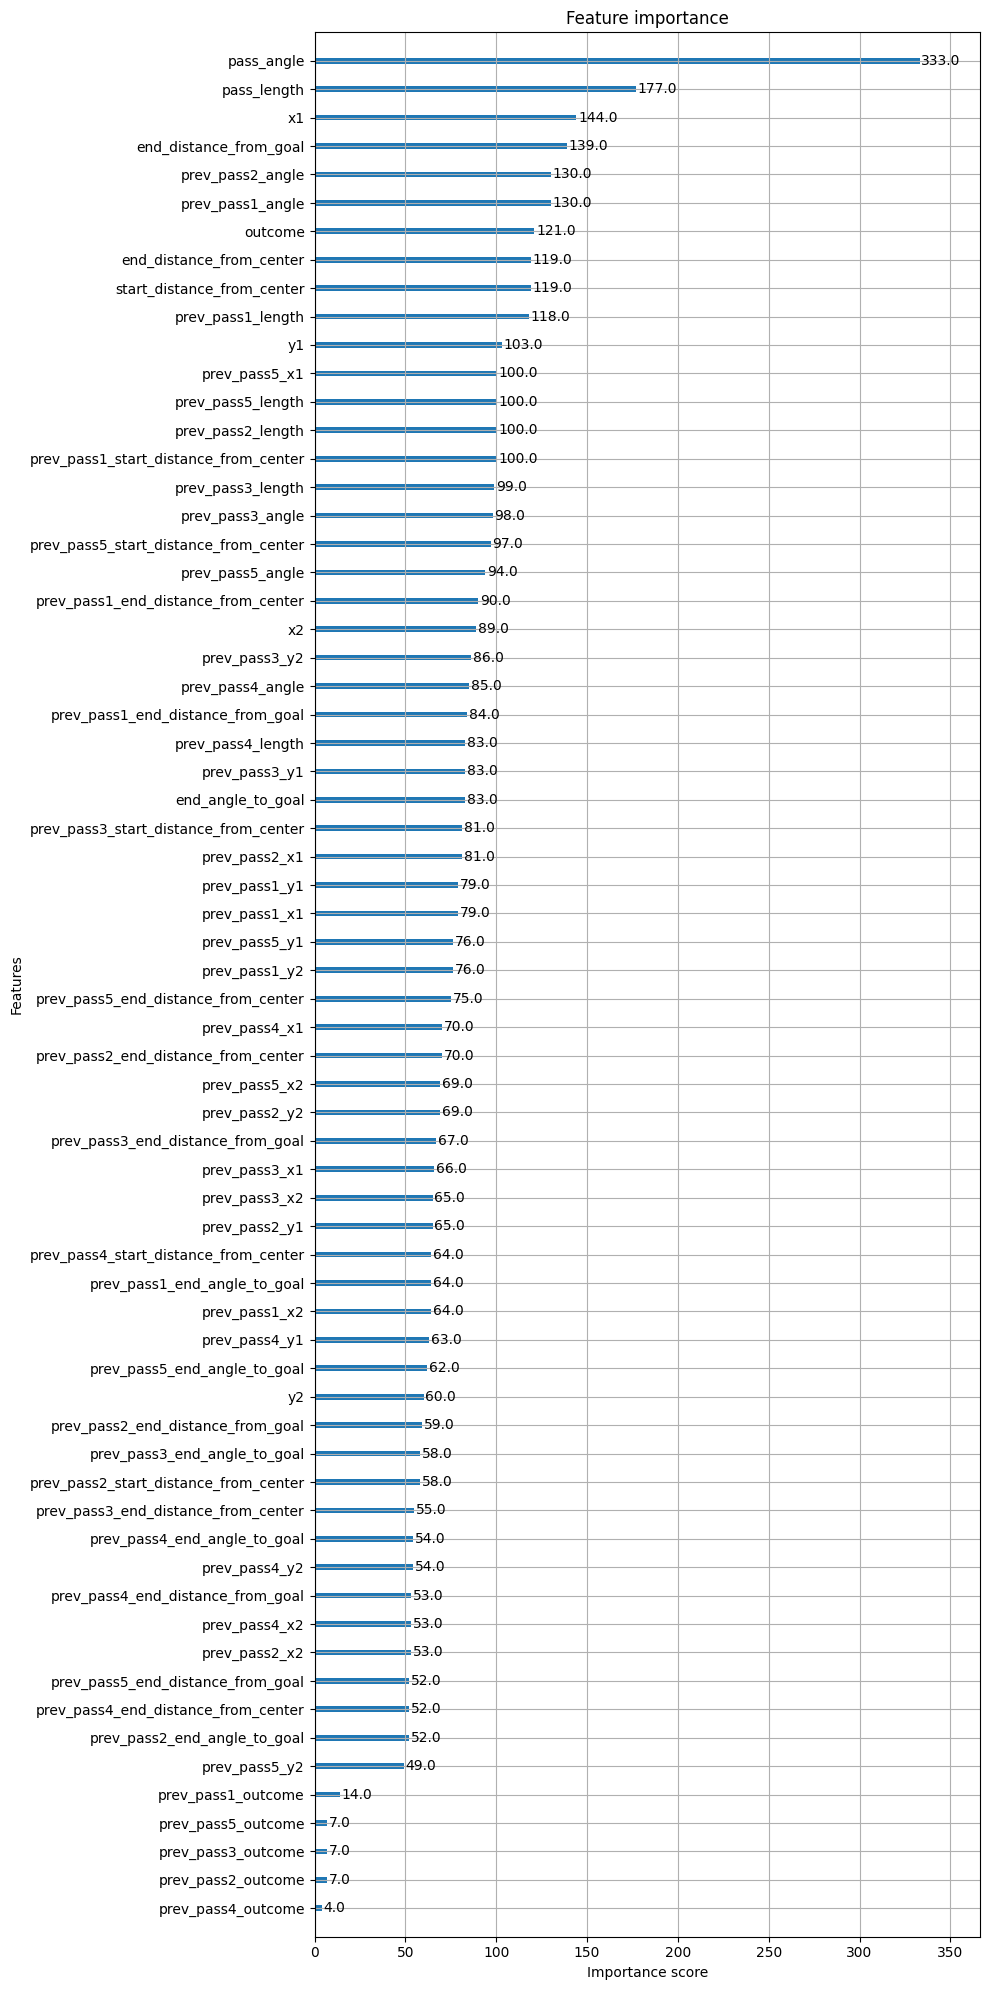

In [88]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model,ax=ax)
plt.tight_layout()
plt.show()

In [89]:
y_pred.max()

0.5339238

In [82]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # RMSE (negated, because higher = better)
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

# Evaluate on validation set
y_pred = grid_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("Validation RMSE:", rmse)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV RMSE: 0.0581861865172254
Validation RMSE: 0.0031565340285147295


In [85]:
model = grid_search.best_estimator_

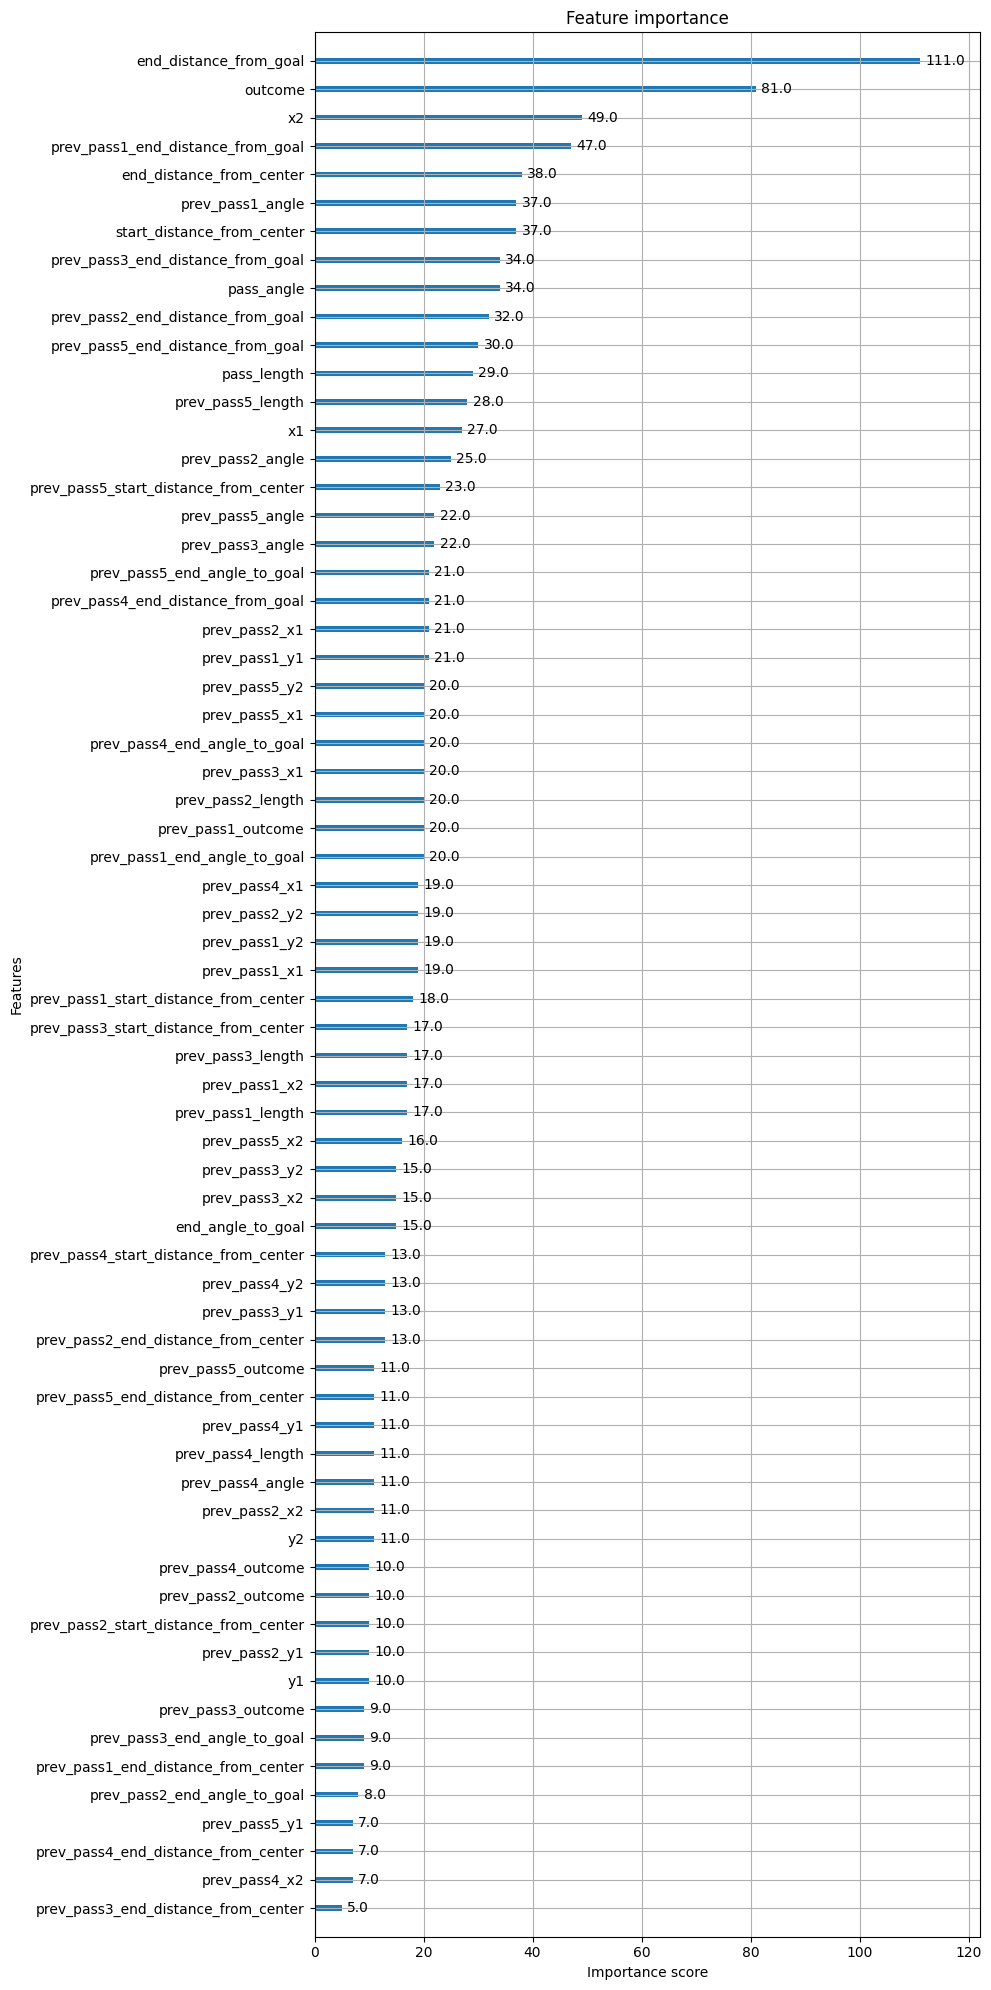

In [86]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model,ax=ax)
plt.tight_layout()
plt.show()

# Finding how possessions start

In [64]:
#how possessions start


"""If start is pass check the event before the pass
   if the start is interception log the pass before that was intercepted
   during the possession if there is a string of opponent passes at the start find the last pass/event before it starts the possesion for current team"""

origins = ordered_events.groupby("possession").first().reset_index()[["possession","type","outcome"]]
origins.head(50)

,possession,type,outcome
0,2,Pass,1.0
1,3,Duel,1.0
2,4,Clearance,1.0
3,5,Throw-in,1.0
4,6,Duel,0.0
5,7,Clearance,1.0
6,8,Free Kick,1.0
7,9,Throw-in,1.0
8,10,Free Kick,1.0
9,11,Pass,0.0
